# *Lecture 6*


# Advanced Monte Carlo Integration Methods and Applications
## (von Neumann Method, Metropolis Algorithm, and Ising Model)

| |
|:---:|
|Selected Content [From **COMPUTATIONAL PHYSICS**, 3rd Ed, 2015](http://physics.oregonstate.edu/~rubin/Books/CPbook/index.html) <br>RH Landau, MJ Paez, and CC Bordeianu (deceased) <br>Copyrights: <br> [Wiley-VCH, Berlin;](http://www.wiley-vch.de/publish/en/books/ISBN3-527-41315-4/) and [Wiley & Sons, New York](http://www.wiley.com/WileyCDA/WileyTitle/productCd-3527413154.html)<br>  R Landau, Oregon State Unv, <br>MJ Paez, Univ Antioquia,<br> C Bordeianu, Univ Bucharest, 2015.<br> Support by National Science Foundation.|
| Additional content from By HeMath [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)], from Wikimedia Commons

## Physics Application: Ising model of magnetization

<img src="Figures/Figure_17.1.png" width="40%">

Ferromagnetism is due to the net alignment of atomic spins in a material (technically the nuclear magnetic dipole moment).
Ferromagnets contain finite-size *domains* in which the spins point in the same direction, giving rise to a large net magnetization in a limited region.

When an external magnetic field is applied to these materials, the different domains align and the materials become “magnetized.”
As the temperature is raised, the total magnetism decreases, and at the Curie temperature $T_C$ the system goes through a *phase transition* beyond which all net magnetization vanishes.
When the system is cooled down again, the magnetic domains reappear from the disordered structure, as seen in the figure below.

<img src="Figures/Ising_quench_b10.gif" width="60%">

How can we model this phase transition computationally, taking into account the interactions between all of the atoms and the magnetic field?

## Monte Carlo Integration

The general Monte Carlo integration rule was presented last time:
$$\int_{a}^{b} \ dx \  f(x) \simeq
(b-a)\frac{1}{N} \sum_{i=1}^{N} f(x_{i}) = (b-a) \langle f
\rangle$$

The challenge is to determine a sequence of $x_i$ that helps the estimate converge to the true value of the integral as fast as possible (with minimal $N$).

$$\begin{align}
\sigma_I^2 &\simeq \frac{1}{N} \sigma_f^2 \\
&= \frac{1}{N} \left[ \frac{1}{N} \sum_{i=1}^N f_i^2 - \left( \frac{1}{N} \sum_{i=1}^N f_i \right)^2 \right]
\end{align}$$

In this course, we focus on the following methods for generating the $x_i$ sequence:
* uniform sampling throughout the interval
* importance sampling via integration of weighting function and analytic inversion of cumulative probability distribution
* importance sampling via von Neumann method (acceptance/rejection method)
* importance sampling via Metropolis algorithm (Markov chain random walk)

We have covered the first two methods in a previous lecture, and we will cover the last two methods in this lecture.

### Importance Sampling

Let us compare the $x_i$ used in uniform sampling and importance sampling.  We plot each point at ($x_i, f(x_i))$.

In the following examples, we are estimating the integral
$$\int_0^1 \frac{dx}{1+x^2}$$

For N= 10 :  0.7893265351049928 +/- 0.04829174987107919
For N= 10 :  0.7768843334375203 +/- 0.006571471403897414


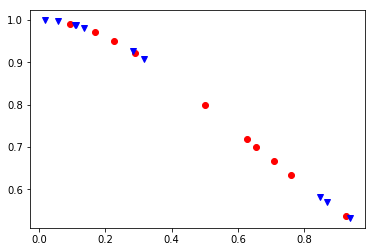

In [13]:
# Monte Carlo integration with uniform sampling and importance sampling
import numpy as np
import matplotlib.pyplot as plt
import random

# Interval of integration is [0,1] in x
def f(x):
    return 1./(1+pow(x,2))

def w(x):
    return (4. - 2.*x)/3.

def xx(y):
    return 2. - np.sqrt(4 - 3*y)

# Uniform sampling
N = 10
sum = 0.
sum2 = 0.
uniform_x_values = []
uniform_f_values = []
for i in range(N):
    x = random.random()
    sum += f(x)
    sum2 += pow(f(x),2)
    uniform_x_values.append(x)
    uniform_f_values.append(f(x))
result = sum/N
sigma = np.sqrt((sum2/N - pow(sum/N,2))/N)
print("For N=", N, ": ", result, "+/-", sigma)

# Importance sampling
sum = 0.
sum2 = 0.
importance_x_values = []
importance_f_values = []
for i in range(N):
    y = random.random()
    x = xx(y)
    integrand = f(x)/w(x)
    sum += integrand
    sum2 += pow(integrand,2)
    importance_x_values.append(x)
    importance_f_values.append(f(x))
result = sum/N
sigma = np.sqrt((sum2/N - pow(sum/N,2))/N)
print("For N=", N, ": ", result, "+/-", sigma)

plt.plot(uniform_x_values, uniform_f_values, 'ro')
plt.plot(importance_x_values, importance_f_values, 'bv')
plt.show()

The blue triangles from the importance sampling tend to be in the region where the weighting function values are large.  There are two things to note about both:
* There is no order to the random numbers.  A point is not necessarily followed by another point nearby.
* There is no correlation between the numbers in the sequence.  This is crucial to our formula for the uncertainty estimate.

*Question*: How can we get the same estimate for the integral, approximated by the sum of function values, when the "random" sequence is biased toward the high function values?  
*Answer*: The answer is that the integrand in importance sampling is not $f(x)$ or even $f(x(y))$.
Instead it is $f(x)/w(x)$, and $w(x)$ also happens to be large where $f(x)$ is large.  The sequence bias toward large values of $w(x)$ is compensated by the $1/w(x)$ in the integrand.

## von Neumann method (acceptance/rejection)

It may happen that inverting $y(x) = \int_a^x w(t) \, dt$ is too complicated.
(Inverting anything more complicated than a 3-order polynomial is complicated!)
In that case, it is not possible to provide an analytic transform from a uniform sequence in $y$ to an appropriate weighting in $x$.

In such a case, we need a different way to generate a random sequence that has an arbitrary probability distribution.
The von Neumann method (also known as the acceptance/rejection method) accomplishes this.

1. Imagine a graph of $w(x)$ *vs.* $x$.
Construct a rectangular area (box) extending from $a$ to $b$ in $x$ and from $w_\text{min}$ to $w_\text{max} \equiv W_0$ in $W$.
In fact, the top and bottom edges of the box can be any values, as long as all possible values of $w(x)$ are included.

<img src="Figures/Figure_5.8.png" width="40%">

By the way, note the clear distinction here between $w(x)$ and $W$.
$W$ has nothing to do with $w(x)$, except that we will be comparing the $W$ values to the $w(x)$ value.

2. Now generate uniform distributions in $x$ and $y \equiv W$
with the maximum $y$ value equal to the top of the box
$W_0$:
$$(x_{i}, W_{i}) = ((b-a)r_{2i-1}, W_{0}r_{2i})$$
Practically, this amounts to generate random $r_1$ and $r_2$ values that are uncorrelated.  Note that the results from `random()` must be rescaled to give numbers in the correct range.  An alternative is to use `uniform(a,b)`, which directly returns a number between $a$ and $b$.

3. Reject all $(x_i, W_i)$ points that do not fall into the region below the curve:
$$
\mbox{If} \ W_{i} \lt w(x_{i}),  \ \mbox{accept}, \quad
  \mbox{If} \ W_{i} \gt w(x_{i}),\  \mbox{reject}$$
The $x_i$ values that are accepted will naturally have the weighting
probability $w(x)$. The largest acceptance occurs where $w(x)$ is
large, as shown for midrange $x$ in the figure.

Since we are using the weighting function $w(x)$, the terms in the integration formula are not simply $f(x_i)$, but rather $f(x_i)/w(x_i)$.

In our example, $W_0=4/3$, the maximum value of the weighting function in the interval [0,1].  If you are not sure of the maximum value, you can plot the function and check.

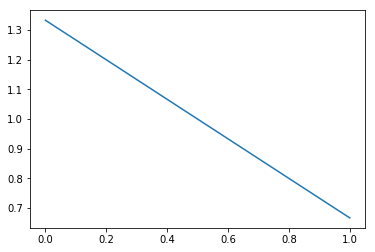

In [15]:
def w(x):
    return (4. - 2.*x)/3.

x_values = []
w_values = []
for x in np.linspace(0,1,20):
    x_values.append(x)
    w_values.append(w(x))
plt.plot(x_values, w_values)
plt.show()


For N= 20 :  0.790598555541137 +/- 0.003908458565066963


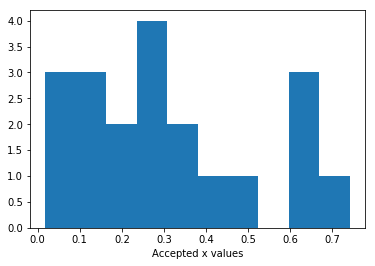

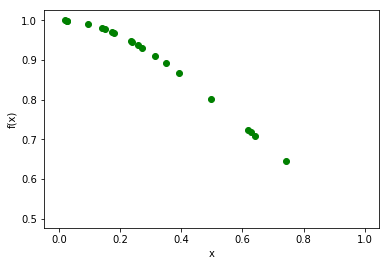

Number accepted: 20
Number rejected: 240


In [21]:
# Implementation of acceptance/rejection method

def f(x):
    return 1./(1+pow(x,2))

def w(x):
    return (4. - 2.*x)/3.
# Max value of w over [0,1] is 4/3
#w0 = 4.0
w0 = 4./3.

accepted_x_values = []
rejected_x_values = []
accepted_f_values = []
rejected_f_values = []
accepted_w_values = []
rejected_w_values = []

N = 20
sum = 0.
sum2 = 0.
naccepted = 0
while naccepted < N:
    trial_x = random.random()
    trial_y = random.uniform(2./3., 4.)        # random number in specific interval
    if trial_y < w(trial_x):
        accepted_x_values.append(trial_x)
        accepted_w_values.append(w(trial_x))
        accepted_f_values.append(f(trial_x))
        integrand = f(trial_x)/w(trial_x)
        sum += integrand
        sum2 += pow(integrand,2)
        naccepted += 1
    else:
        rejected_x_values.append(trial_x)
        rejected_w_values.append(w(trial_x))
        rejected_f_values.append(f(trial_x))
result = sum/N
sigma = np.sqrt((sum2/N - pow(sum/N,2))/N)
print("For N=", N, ": ", result, "+/-", sigma)

plt.hist(accepted_x_values)
plt.xlabel('Accepted x values')
plt.show()

plt.plot(rejected_x_values, rejected_f_values, 'wo')
plt.plot(accepted_x_values, accepted_f_values, 'go')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

print("Number accepted:", len(accepted_x_values))
print("Number rejected:", len(rejected_x_values))


The fraction of trial x values accepted depends on the value of $W_0$.  
(Sometimes this fraction is called the "efficiency" or "computational efficiency.")
If we use a very large $W_0$, the efficiency will be low, but it doesn't matter.
Only the accepted values are used, and they **will** have the correct distribution, one that follows $w(x)$.

Generating random values is approximately free.  If the efficiency is *very* low, that will slow down the integration because lots of values will be generated and immediately rejected.

It is important that the $N$ value in the $\left< f \right>$ calculation be the number of accepted points, not the number of accepted + rejected.  This is because the rejected points are not used to calculate the mean.

Also note that we have not multiplied by $b-a$ in the code snippet above; we have only calculated $\left< f \right>$ with this sum over many $x_i$ values.
Fortunately the interval in this case is just $b-a=1-0=1$, so we still get a correct estimate!
This will not always be the case, so don't forget to multiply $\left< f \right>$ by the interval!

The advantage of the von Neumann method is that it can deal with arbitrarily complicated weighting functions in a straightforward way.
The main disadvantage (besides possibly low computational efficiency) is that the weighting function may be very complicated (due to a large number of dependencies and dimensions) and therefore inconvenient to sample.

The reason for this is that using a simple hypercube as a trial volume does not capture the correlated variations of $w(\vec{x})$ in multiple dimensions.
Notice how the weighting function below is not efficiently sampled with random numbers in $(x,y)$.

<IPython.core.display.Javascript object>


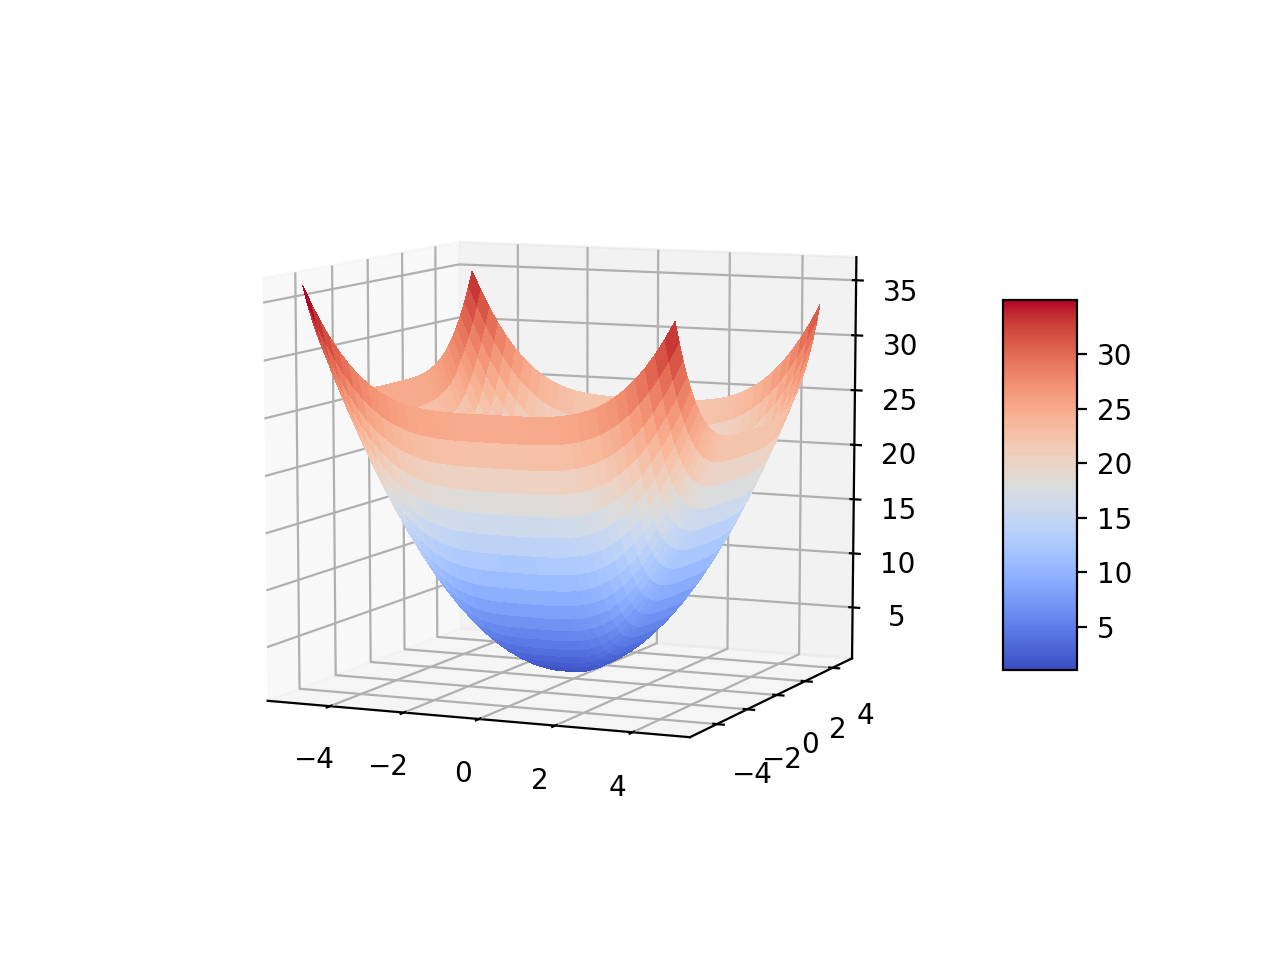

In [41]:
% matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
#, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**4 + Y**4)
#Z = np.sin(R)
Z = R + 1

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

It is possible to correct for this by choosing a smarter $W_0(\overrightarrow{x})$ to increase efficiency.  (Instead of a constant $W_0$, pick something that follows closely the variations in $w(\overrightarrow{x})$ throughout the entire range of integration.)

The next method overcomes this challenge by introducing a random walk around the interval, with a preference for lingering in the regions where $w(x)$ is large.

## Metropolis algorithm

The Metropolis algorithm is a modification of the von Neumann acceptance/rejection technique.
The difference is that the sequence of random points is generated by a random walk through the $x$ interval (or higher dimensions).
As the walk becomes longer and longer (more points), the sequence approaches more closely the desired weighted distribution.

The sequence of random points (which may be random physical configurations like the Ising model) are a *Markov chain*, in which the next point in a sequence depends only on the current point and not on the past history of the system.

*Question*: is exponential decay a Markov chain process?  Why or why not?

### Implementation

Here is the general approach to creating a random walk for the Metropolis algorithm in 1 dimension.
1. Assume the walker is at a point $x_i$.  The choice of initial state is usually not important, as long as enough points are considered that the system reaches some equilibrium.
2. To generate $x_{i+1}$, make a trial step to a new point $x_t$.  (Notice that it is not called $x_{i+1}$ yet!)  The size of the step is an important parameter that must be tuned (see below).
3. Decide if the trial step is accepted or rejected by calculating the ratio $r = w(x_t)/w(x_i)$.  If $r\geq1$, then the trial step is accepted.  If $r < 1$, then the step is accepted only with probability $r$.  That is, $r$ is compared with a random number $\eta$ in [0,1] and accepted if $\eta<r$.  If the step is accepted in one of these two ways, $x_t$ becomes $x_{i+1}$.
4. Repeat from this new point.

With this method, the walker tends to move more often toward regions of $x$ where $w(x)$ is large.
But it can move away from those regions if the penalty is not large.
Of course, if $w(x)$ is very small everywhere except in one subregion, the walker is unlikely to move very far away from that subregion.

How should the trial step be chosen?  
If it is too small, most trials will be accepted, but the random walker will not get very far, so it will not sample $w$ very well.
If it is too big, then $w(x_t)/w(x_i)$ will usually be small, and most trials will be rejected.
A good rule of thumb, given by Koonin, is that the trial step size should be chosen so that about half of the trial steps are accepted.

0 0
fail
fail
fail
fail
fail
1 0.33638997576342555
fail
2 0.3247312705026556
fail
3 0.004316102110825448
fail
4 0.3885842121049825
5 0.2926136636556649
6 0.11663650581398988
7 0.491031041626093
8 0.6437134177019223
9 0.8020804722993061
fail
10 0.7612406802819105
11 0.8187659615868598
12 0.7680393263987338
13 0.7668731728773956
14 0.8711325411062699
15 0.9749392857931085
16 0.8841337933021877
17 0.9556065388002093
fail
fail
fail
18 0.7074649932362224
19 0.9666707345121988
20 0.7178311009444602
21 0.7103710129970324
22 0.7937350836954706
23 0.5621901257719816
24 0.10287789668800873
fail
25 0.1997315276973387
fail
fail
26 0.16534227562674264
27 0.03712200090427431
fail
28 0.030006602375698965
fail
fail
fail
fail
29 0.17110531301357879
fail
fail
fail
fail
30 0.4067917870203571
31 0.35938486845948237
32 0.34606433134020487
fail
33 0.5105338916132375
34 0.38636198639786745
35 0.3952827452000056
36 0.20439916828514537
37 0.42567415516501117
38 0.6978201765609966
39 0.5611512510978109
40 0.856

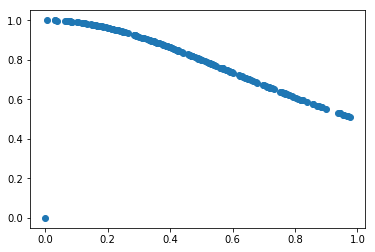

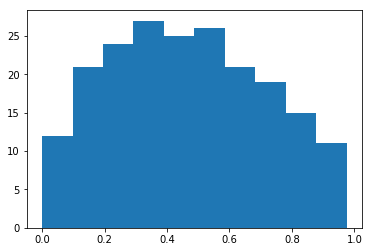

In [45]:
% matplotlib inline
# Taking a random walk inside the Metropolis algorithm
def f(x):
    return 1./(1+pow(x,2))

def w(x):
    if x<0 or x>1:
        return 0.
    else:
        return (4. - 2.*x)/3.

# Get the next accepted point in the random walk
def metropolis(x, w, delta):
    while 1:
        # Take the trial step
        x_t = x + delta*random.uniform(-1.,1.)
        r = w(x_t)/w(x)
        if r > random.random():
            # Step accepted
            return x_t
        else:
            print("fail")

N = 200
delta = 0.5
metropolis_x_values = []
metropolis_f_values = []
metropolis_x_values.append(0)
metropolis_f_values.append(0)
for i in range(N):
    x = metropolis_x_values[i]
    print(i, metropolis_x_values[i])
    next_x = metropolis(x, w, delta)
    metropolis_x_values.append(next_x)
    metropolis_f_values.append(f(next_x))

plt.plot(metropolis_x_values, metropolis_f_values, 'o')
plt.show()

plt.hist(metropolis_x_values)
plt.show()


We modified our function so that the $x$ values cannot go outside the desired interval [0,1].  Usually the Metropolis algorithm is used for integrals on the interval $[-\infty, \infty]$.

It is also common for the random walk to proceed in a space of system states instead of a 1-dimensional interval.
One example is the Ising model of a large number of atomic spin states that align to give a net magnetization in well-defined *domains*.

## Back to the Application: Ising model of magnetization

As our model we consider $N$ magnetic dipoles fixed in place on the
links of a linear chain.  We assume that the atom at site
$i$ has spin $s_{i}$, which is either up or down.

<img src="Figures/Figure_17.1.png" width="40%">

The energy of the system arises from the interaction of the spins with
each other and with the external magnetic field $B$. We know from
quantum mechanics that an electron’s spin and magnetic moment are
proportional to each other, so a magnetic *dipole-dipole*
interaction is equivalent to a *spin-spin* interaction. We
assume that each dipole interacts with the external magnetic field and
with its nearest neighbor only through the potential:

$$V_{i} = - J\textbf{s}_{i}\cdot\textbf{s}_{i+1} - g \mu_b
\textbf{s}_{i}\cdot \textbf{B}$$

Here the constant $J$ is called the *exchange energy* and is a measure
of the strength of the spin-spin interaction relative to $g\mu_B$.

The energy of this system in state $\alpha_k$ is the expectation value
of the sum of the potential $V$ over the spins of the particles:

$$E_{\alpha_k} = \Big\langle \alpha_k \Big|\sum_{i}V_{i}
\Big| \alpha_k \Big\rangle = -J \sum_{i=1}^{N-1} s_{i}s_{i+1} - B
\mu_b\sum_{i=1}^{N} s_{i}$$

We will focus on the case of no magnetic field, meaning that there are just spin-spin
interactions. However, be cognizant of the fact that this means there is no
preferred direction in space (spin "up" and "down" have no meaning), 
and so you may have to be careful how you
calculate observables. For example, you may need
to take an absolute value of the total spin when calculating the magnetization,
that is, to calculate $\langle \left | \sum_i s_{i}\right| \rangle$ rather than
$\langle \sum_i s_{i}\rangle$.

The equilibrium alignment of the spins depends critically on the sign of
the exchange energy $J$. If $J>0$, the lowest energy state will tend to
have neighboring spins aligned. If the temperature is low enough, the
ground state will be a *ferromagnet* with all the spins aligned. Yet if
$J<0$, the lowest energy state will tend to have neighbors with opposite
spins. If the temperature is low enough, the ground state will be a
*antiferromagnet* with alternating spins.

We expect that the energy $E_{\alpha_j}$ of state $\alpha_{j}$
is not constant but is distributed with probabilities $P(\alpha_{j})$
given by the Boltzmann distribution at temperature $T$:

$$
 {\cal P}(E_{\alpha_{j}},T)= \frac{e^{-E_{\alpha_j}/k_BT}}
{Z(T)},\quad Z(T)=
\sum_{\alpha_{j}}e^{-E_{\alpha_j}/k_BT}$$

In the end, we are even able to ignore the partition
function $Z(T)$ because it cancels out when we calculate the *ratio* of
probabilities.

### Implementation of Metropolis algorithm

The
Metropolis algorithm produces a *Markov chain* of states that
accurately simulate the fluctuations that occur during thermal
equilibrium. The algorithm randomly changes the individual spins such
that, on the average, the probability of a configuration occurring
follows a Boltzmann distribution.

We start with a fixed temperature and an initial spin configuration, and apply
the algorithm until a thermal equilibrium is reached (equilibration at a stable energy).
Continued application of the algorithm generates the statistical
fluctuations about equilibrium from which we deduce the thermodynamic
quantities such as the magnetization $M(T)$. Then the temperature is
changed, and the whole process is repeated in order to deduce the $T$
dependence of the thermodynamic quantities.

The explicit steps of the Metropolis algorithm are:

1.  Start with an arbitrary spin configuration $\alpha_{k}=\{s_1,
    s_2, \ldots, s_N\}$.

2.  Generate a trial configuration $\alpha_\text{tr}$ by
    -   picking a particle $i$ randomly and
    -   flipping its spin

3.  Calculate the energy $E_{\alpha_{\text{trial}}}$ of the
    trial configuration.

4.  If $E_{\alpha_{\text{trial}}} \leq E_{\alpha_{k}}$, accept the trial by
    setting $\alpha_{k+1} = \alpha_{\text{trial}}$.

5.  If $E_{\alpha_{\text{trial}}} > E_{\alpha_{k}}$, accept with relative
    probability $ {\cal R} = \frac{\exp(E_{\alpha_{\text{trial}}}/k_B T)}{\exp(E_{\alpha_{k}}/k_B T)} = \exp(-\Delta E/k_B T)$, with $\Delta E = E_{\alpha_{\text{trial}}} - E_{\alpha_{k}}$:

    -   Choose a uniform random number $0 \leq r_i \leq
           1$

    -   Set $\alpha_{k+1} = \begin{cases}
        \alpha_{\text{trial}}, & \mbox{if} \ \  {\cal R} \geq r_i  \ \
        \mbox{(accept)},\\
        \alpha_{k}, & \mbox{if}\ \  {\cal R} < r_i \ \
        \mbox{(reject)}.
        \end{cases}$

The heart of this algorithm is its generation of a random spin configuration
$\alpha_{j}$ with probability 
$$
 {\cal P}(E_{\alpha_{j}},T) \propto e^{-
E_{\alpha_j}/k_BT}$$ 
This is used in Step 5 to calculate $\mathcal{R}$.

Note that if $\mathcal{R}>1$, then the step is accepted immediately, and if $1 > \mathcal{R} \geq r_i$ the step is still accepted.  So in the end, the condition for acceptance is just $\mathcal{R}\geq r_i$.

It is a bit daunting to program the Metropolis algorithm.  The following code has the same skeleton as the textbook listing, but it has been edited for clarity and parts rewritten.

The Ising model simulation shows the development of magnetic domains, regions with spins pointed in the same direction.  The following visualization uses "X" for spin +1 and "O" for spin -1.

OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOOOOOOOOOOOOXOOOOOOOOOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOOOOOOOOOOOOXOOOOOOOOOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOOOOOOOOOOOOXOOOOOOOOOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOOOOOOOOOOOOXOOOOOOOOOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOOOOOOOOOOOOXOOOOOOOOOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOOOOOOOOOOOOXOOOOOOOOOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOOOOOOOOOOOOXOOOOOOOOOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOOOOOOOOOOOOXOOOOOOOOOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOOOOOOOOOOOOXOOOOOOOOOOOOOOXOOOOOOOO
OOOOOOOOOOOOOOOOOOOOOOOOOOXOOOOOOOOOOOOOOXOOOOOOOO
OOOOOOOOOOOOOOOOOOOOOOOOOOXOOOOOOOOOOOOOOXOOOOOOOO
OOOOOOOOOOOOOOOOOOOOOOOOOOXOOOOOOOOOOOOOOXOOOOOOOO
OOOOOOOOOOOOOOOOOOOOOOOOOOXOOOO

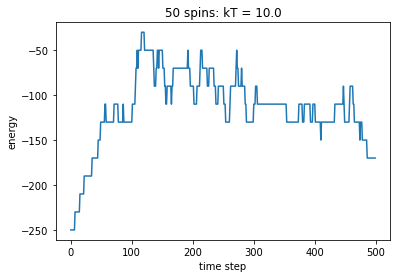

In [75]:
# Ising model implementation with Metropolis algorithm
# Based on IsingViz.py from Landau, et al.

N     = 50                 # number of spin sites                                     
B     = 0.                 # magnetic field                               
mu    = .33                # g mu (not needed if B=0)
J     = 5.                 # exchange energy                              
k     = 1.                 # Boltzmann constant
T     = 10.                 # temperature                                 
state = np.zeros(N)        # spin states: up(1), down (-1)
random.seed() 
        
def energy(S):                                  
    FirstTerm = 0.
    SecondTerm = 0.                                          
    for i in range(0,N-1):  
        FirstTerm += -J * S[i]*S[i+1]
    FirstTerm += -J * S[N-1]*S[0]     # periodic boundary 
    for i in range(0,N):   
        SecondTerm += -mu*S[i]*B
    return (FirstTerm + SecondTerm); 

for i in range(0 ,N):  
    state[i] = -1.          # Initial spins all down (cold start)  

ES = energy(state)
    
num_steps = 10*N
energy_values = []
step_index_values = []
for istep in range(num_steps):
    test_state = list(state)
    random_site = int(N*random.random())
    test_state[random_site] *= -1.   # Trial step: flip spin at one random site
    ET = energy(test_state)
    R = np.exp((ES-ET)/(k*T))           # Boltzmann test
    #print(ES, ET, k*T, R)
    if R > random.random():
        state = test_state
        ES = ET
    # else nothing (we remain in the same state as before)
    
    energy_values.append(ES)
    step_index_values.append(istep)
    row = ''
    for site in state:
        if site==1.0:
            row += 'X'
        else:
            # fancy codes for red O's
            row += '\x1b[31mO\x1b[0m'
    print(row)
    
plt.plot(step_index_values, energy_values)
plt.xlabel('time step')
plt.ylabel('energy')
plt.title('%d spins: kT = %.1f' % (N, k*T))
plt.show()


We might like to do a little bit of smoothing, since we really want to measure the energy in some equilibrium state.  One way to do this is to take a running average of energy values.  We might use a sliding window of 20 measurements to capture the running average.

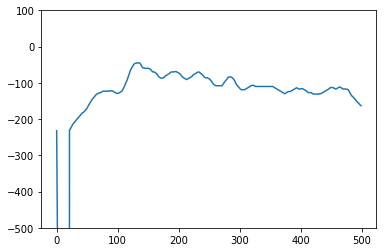

In [76]:
N = 20
sum = 0.
running_average_values = []
for step_index in step_index_values:
    if (step_index > N):
        sum = 0.
        for i in range(step_index-N, step_index):
            sum += energy_values[i]
    else:
        for i in range(N):
            sum += energy_values[i]
    average = sum/N
    running_average_values.append(average)

plt.plot(step_index_values, running_average_values)
plt.ylim(-500., 100.)
plt.show()

The Metropolis algorithm is an example of a Markov Chain Monte Carlo method because the next state in the random walk depends only on the current state, not on the history of the system.

This random walk through the Ising model spin configurations could not be replaced by a simple acceptance/rejection method or other analytic importance sampling.  In this case, the random walk explores a space that is not a continuous interval.
